## Notebook set up

Submit your notebook to the class leaderboard on HuggingFace at [huggingface.co/spaces/gperdrizet/leaderboard](https://huggingface.co/spaces/gperdrizet/leaderboard)

**Your task**: Apply at least two different feature engineering techniques to the `housing_df` dataframe to improve the dataset. At the end of the notebook, your engineered dataset and the original dataset will be used to train a linear regression model to predict `MedHouseVal`. Your goal is to achieve better model performance via feature engineering.

Don't change any of the code in the Model evaluation section of the notebook, especially the output saving. Otherwise the leaderboard scoring may not work!

**Note**: If you have read ahead or you are familiar with the basics of training ML models, no there is no train-test split and yes, this means data leakage/genralizability is a concern. We will cover those topics in the next unit. For now, the goal is to keep things simple while still giving you an idea of how your feature engineering effects model performance.

Before applying transformations, explore the dataset to understand what techniques would be most beneficial.

### Import libraries

In [152]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

## Custom imports
import pygeohash as pgh
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, PowerTransformer, QuantileTransformer

# Set random seed for reproducibility
np.random.seed(315)

### Load dataset

In [153]:
# Load California housing dataset
original_housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df = original_housing_df.copy()

## Task 1: Explore the dataset

Before deciding what feature engineering techniques to apply, explore the dataset to understand its characteristics.

**Things to investigate**:
- Display basic information about the dataset (`.info()`, `.describe()`)
- Check for missing values
- Examine feature distributions (histograms, box plots)
- Look at feature scales and ranges

Use this exploration to inform your feature engineering decisions in the following tasks.

In [154]:
housing_df.sample(20)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7223,1.8715,34.0,2.942116,1.019960,1962.0,3.916168,34.02,-118.16,1.39600
18989,5.0346,2.0,8.813167,1.307829,1791.0,3.186833,38.36,-121.94,2.05100
17119,4.0039,36.0,5.062762,0.987448,981.0,4.104603,37.48,-122.14,1.48900
19501,2.1528,31.0,4.457286,1.090452,614.0,3.085427,37.66,-121.03,0.75500
13310,4.6167,11.0,4.694836,0.917840,1503.0,3.528169,34.09,-117.61,1.44000
11422,5.6825,24.0,6.699219,1.070312,1601.0,3.126953,33.71,-117.98,2.64600
18065,11.1557,24.0,7.921875,1.088542,539.0,2.807292,37.24,-122.04,5.00001
16471,3.2993,25.0,5.553191,1.148936,789.0,3.357447,38.13,-121.25,0.91100
12219,5.5351,4.0,8.584270,1.250000,2088.0,2.932584,33.55,-117.27,4.29000
12075,5.1950,23.0,6.182390,0.991614,1671.0,3.503145,33.86,-117.60,1.61000


### Sample view
- MedInc - 1.8715 to 11.1567 - Median Income
- HouseAge - 2.0 to 52.0 - House Age
- AveRooms - 2.942116 to 8.813167	- Average num Rooms ---> Clip greater than 25 to 25
- AveBedrms - 0.917840	to 1.187970 - Average num Bedrooms ----> Clip greater than 5 to 5
- Population -	614.0 to 2212.0 - City Population ----> Clip greater than 10,000 to 10,000
- AveOccup - 2.445110 to 4.776243 - Average num People in House  ----> Clip greater than 10 to 10
- Latitude - 33.55 to 38.68           Bin lat long to geohash ()
- Longitude	- -122.43 to -117.34
- MedHouseVal - 0.71400 to 5.00001 - Median House Value (Target)

In [155]:
# YOUR CODE HERE
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [156]:
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [157]:
housing_df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

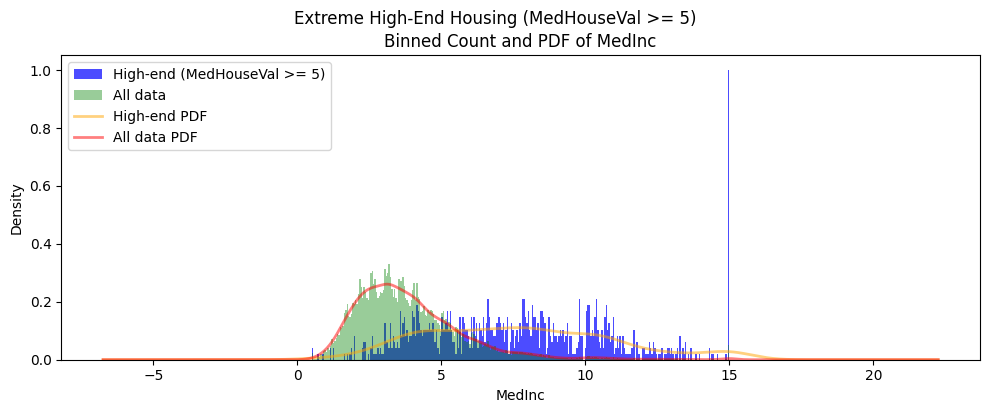

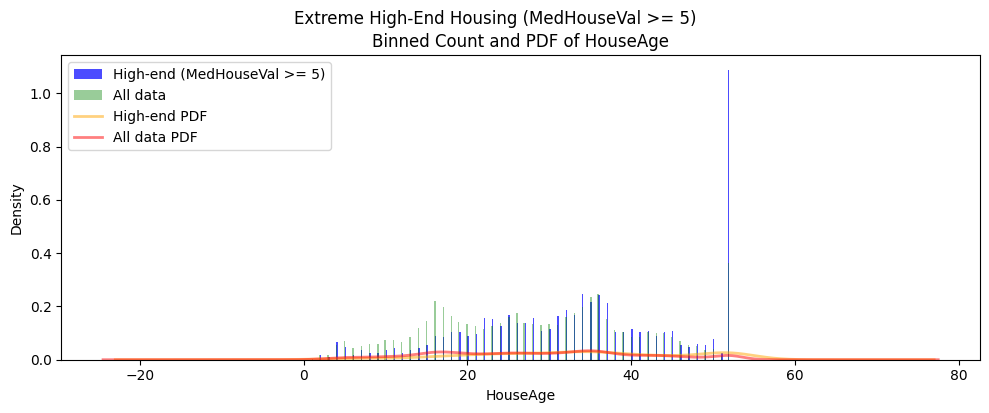

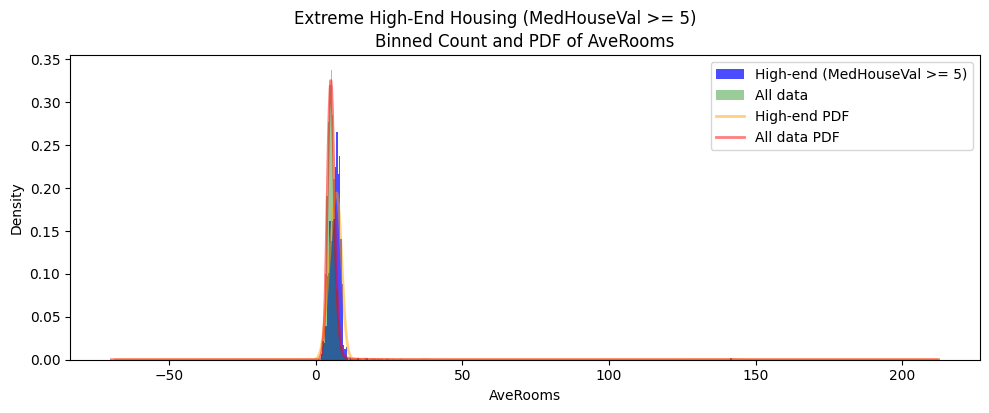

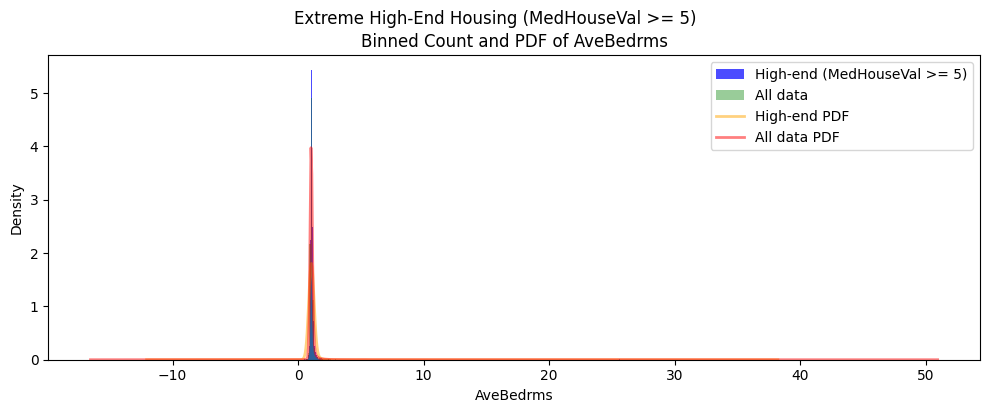

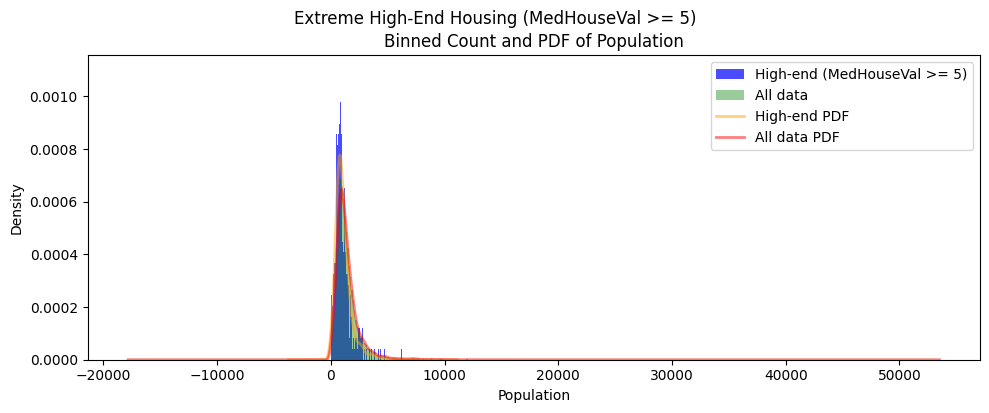

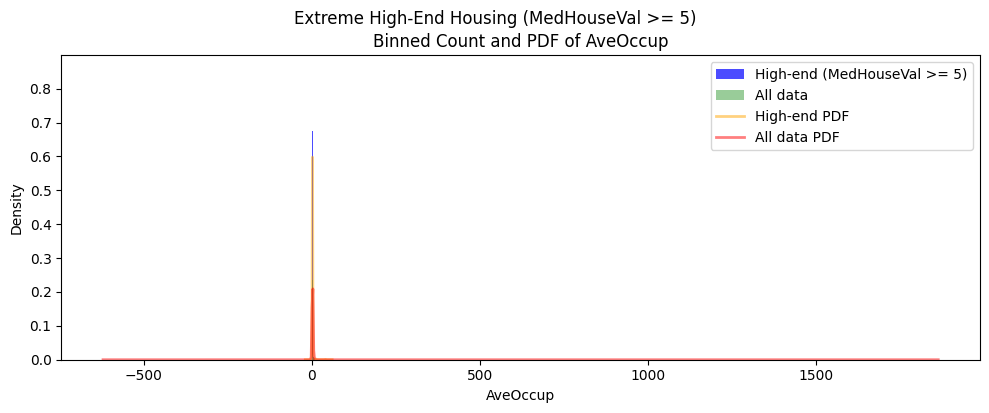

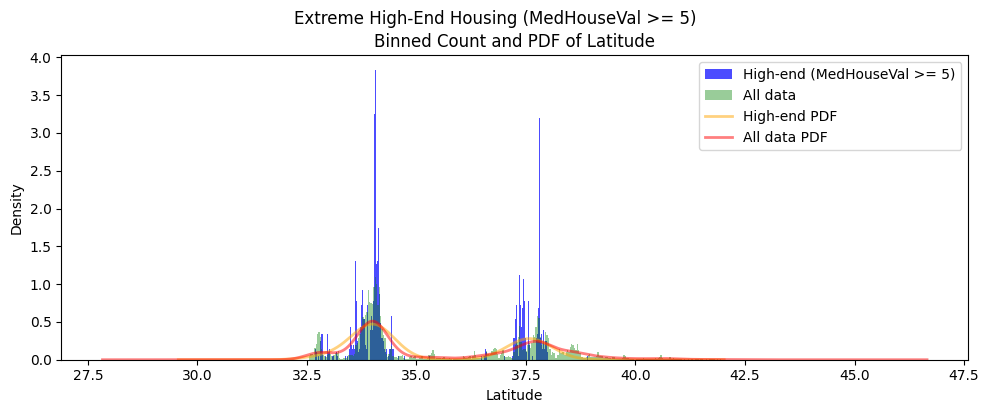

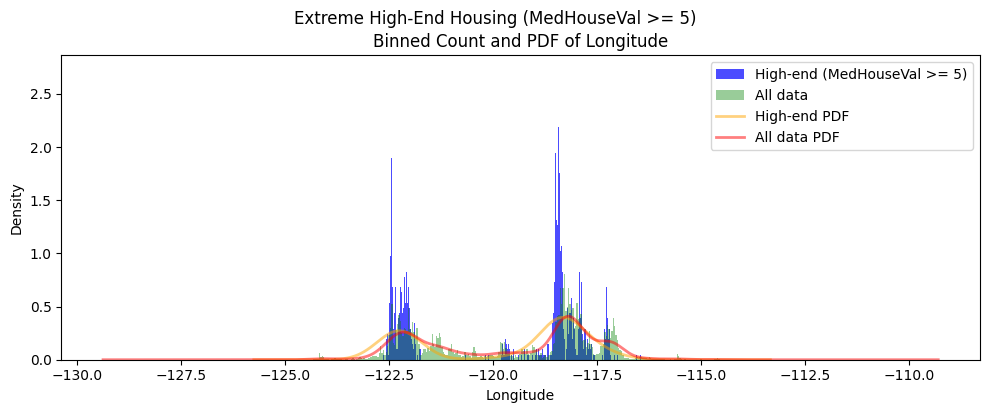

In [158]:
## Determin relationship between extreme MEDHOUSVAL and other features
extreme_highend_housing_df = housing_df[(housing_df['MedHouseVal'] >= 5)]
extreme_highend_housing_df

# Explore features with histograms and PDFs on the same chart
for feature in housing_df.columns.drop('MedHouseVal'):
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Plot histogram with density normalization
    ax.hist(
        extreme_highend_housing_df[feature],
        bins=300,
        density=True,
        alpha=0.7,
        label='High-end (MedHouseVal >= 5)',
        color='blue'
    )
    ax.hist(
        housing_df[feature],
        bins=300,
        density=True,
        alpha=0.4,
        label='All data',
        color='green'
    )
    
    # Plot PDF for high-end subset
    extreme_highend_housing_df[feature].plot(
        kind='density',
        ax=ax,
        linewidth=2,
        label='High-end PDF',
        color='orange',
        alpha=0.5
    )
    # Plot PDF for full data
    housing_df[feature].plot(
        kind='density',
        ax=ax,
        linewidth=2,
        label='All data PDF',
        color='red',
        alpha=0.5
    )
    
    ax.set_title(f"Binned Count and PDF of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()
    plt.tight_layout()
    plt.suptitle('Extreme High-End Housing (MedHouseVal >= 5)', y=1.02)
    plt.show()

In [159]:
'''Perform the following operations:
- MedInc - 1.8715 to 11.1567 - Median Income
- HouseAge - 2.0 to 52.0 - House Age
- AveRooms - 2.942116 to 8.813167	- Average num Rooms ---> Clip greater than 25 to 25
- AveBedrms - 0.917840	to 1.187970 - Average num Bedrooms ----> Clip greater than 5 to 5
- Population -	614.0 to 2212.0 - City Population ----> Clip greater than 10,000 to 10,000
- AveOccup - 2.445110 to 4.776243 - Average num People in House  ----> Clip greater than 100 to 100
'''

housing_df['AveRooms'] = housing_df['AveRooms'].clip(upper=25)
housing_df['AveBedrms'] = housing_df['AveBedrms'].clip(upper=5)
housing_df['Population'] = housing_df['Population'].clip(upper=10000)
housing_df['AveOccup'] = housing_df['AveOccup'].clip(upper=10)
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.396687,1.089361,1421.003101,2.931212,35.631861,-119.569704,2.068558
std,1.899822,12.585558,1.779327,0.285856,1071.516516,0.821141,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,25.000000,5.000000,10000.000000,10.000000,41.950000,-114.310000,5.000010


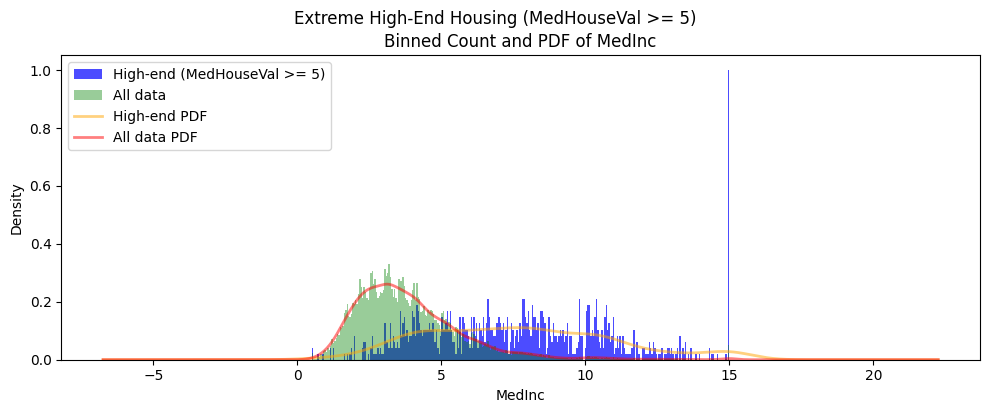

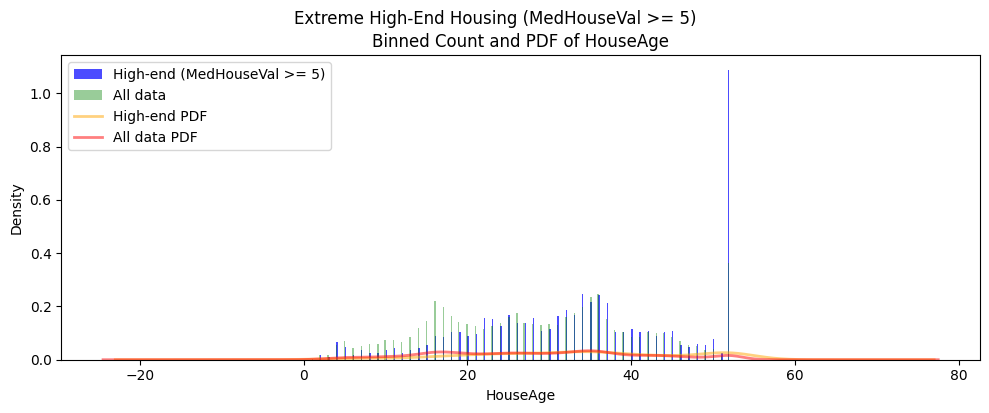

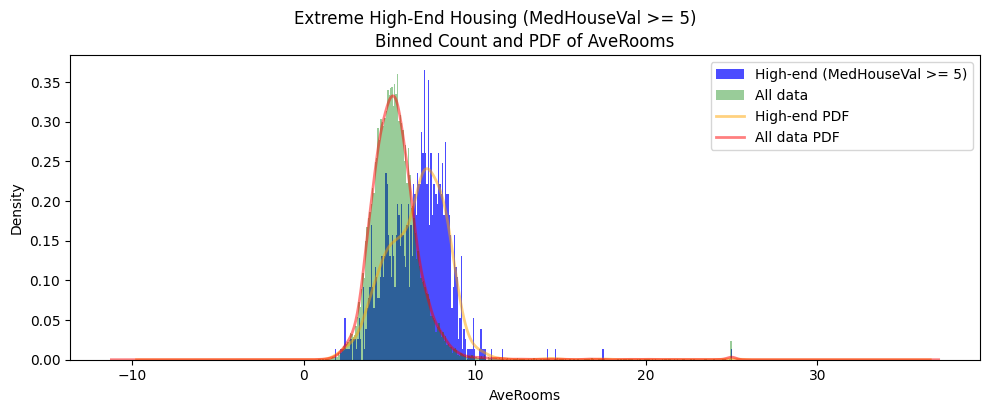

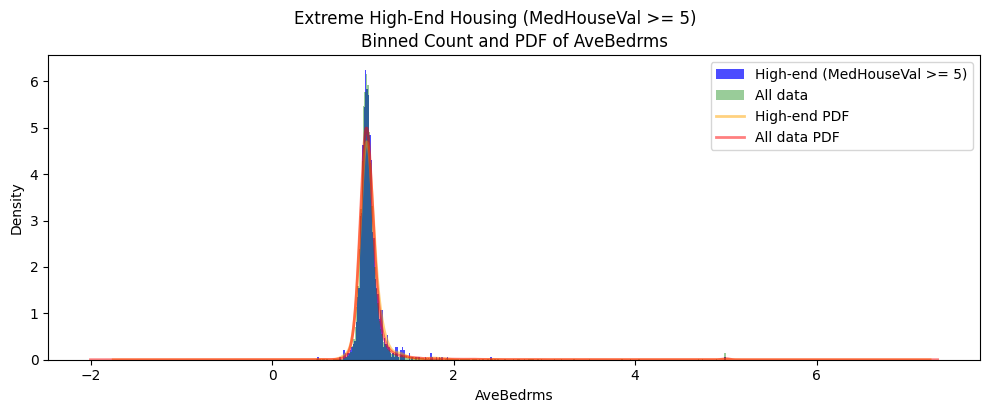

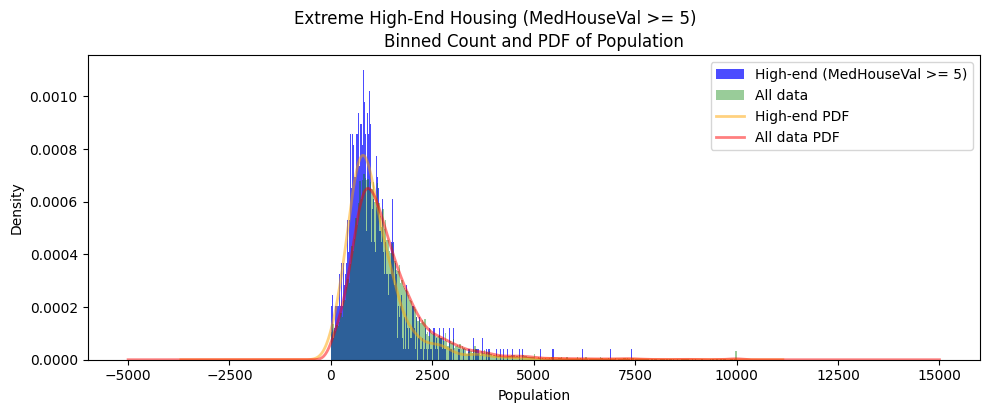

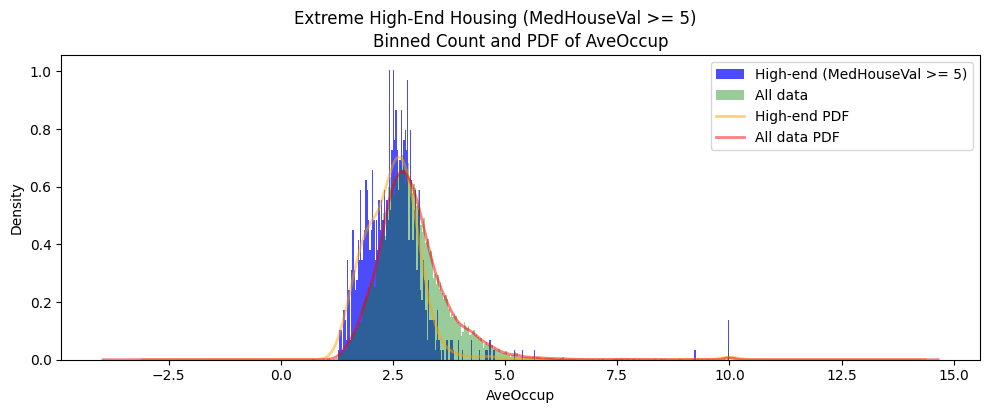

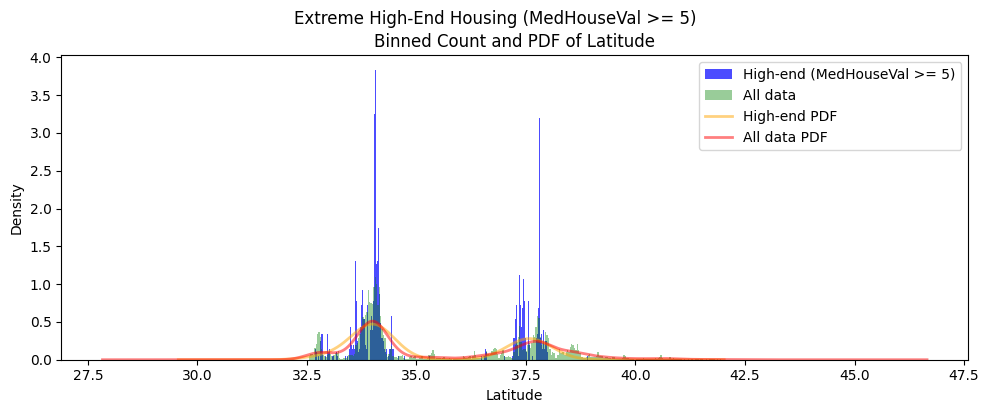

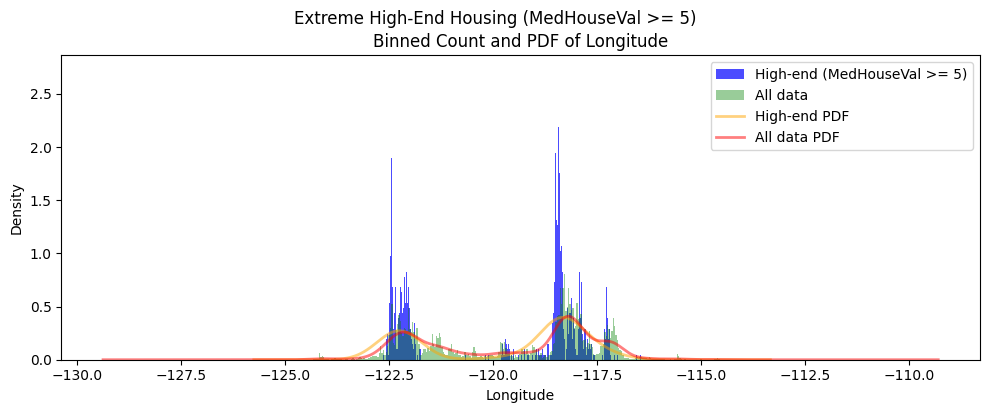

In [160]:
## Determin relationship between extreme MEDHOUSVAL and other features
extreme_highend_housing_df = housing_df[(housing_df['MedHouseVal'] >= 5)]
extreme_highend_housing_df

# Explore features with histograms and PDFs on the same chart
for feature in housing_df.columns.drop('MedHouseVal'):
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Plot histogram with density normalization
    ax.hist(
        extreme_highend_housing_df[feature],
        bins=300,
        density=True,
        alpha=0.7,
        label='High-end (MedHouseVal >= 5)',
        color='blue'
    )
    ax.hist(
        housing_df[feature],
        bins=300,
        density=True,
        alpha=0.4,
        label='All data',
        color='green'
    )
    
    # Plot PDF for high-end subset
    extreme_highend_housing_df[feature].plot(
        kind='density',
        ax=ax,
        linewidth=2,
        label='High-end PDF',
        color='orange',
        alpha=0.5
    )
    # Plot PDF for full data
    housing_df[feature].plot(
        kind='density',
        ax=ax,
        linewidth=2,
        label='All data PDF',
        color='red',
        alpha=0.5
    )
    
    ax.set_title(f"Binned Count and PDF of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()
    plt.tight_layout()
    plt.suptitle('Extreme High-End Housing (MedHouseVal >= 5)', y=1.02)
    plt.show()

## Task 2: Apply your first feature engineering technique

Based on your exploration, apply your first feature engineering technique.

**Example approaches**:
- Transform skewed features using log, sqrt, power, or quantile transformations
- Create bins/categories from continuous variables
- Create interaction features (e.g., rooms per household = total rooms / households)

In [161]:
x_poly = PolynomialFeatures(degree=3)  #3
new_x = x_poly.fit_transform(housing_df.drop(columns=['MedHouseVal']))
new_feature_names = x_poly.get_feature_names_out()

new_housing_df = pd.DataFrame(new_x, columns=new_feature_names)
new_housing_df['MedHouseVal'] = housing_df['MedHouseVal']
housing_df = new_housing_df.copy(deep=True)
housing_df

,1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc^2,...,AveOccup^2 Latitude,AveOccup^2 Longitude,AveOccup Latitude^2,AveOccup Latitude Longitude,AveOccup Longitude^2,Latitude^3,Latitude^2 Longitude,Latitude Longitude^2,Longitude^3,MedHouseVal
0,1.0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,69.308955,...,247.389136,-798.267531,3666.952356,-11832.407244,38180.441856,54353.799872,-175387.142512,565933.749452,-1.826137e+06,4.526
1,1.0,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,68.913242,...,168.531236,-544.054085,3024.204235,-9762.763910,31516.244190,54267.751656,-175187.654712,565542.397224,-1.825689e+06,3.585
2,1.0,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,52.669855,...,297.223199,-959.909216,4014.580565,-12965.451209,41873.097907,54224.761625,-175123.774400,565578.076160,-1.826586e+06,3.521
3,1.0,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,31.844578,...,245.723138,-793.650028,3650.243630,-11789.756507,38079.200342,54224.761625,-175138.100625,565670.615625,-1.827034e+06,3.413
4,1.0,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,14.793254,...,180.120545,-581.763186,3125.218967,-10094.003137,32602.163369,54224.761625,-175138.100625,565670.615625,-1.827034e+06,3.422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.0,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,2.434536,...,258.858650,-793.951214,3991.140873,-12241.318345,37545.624074,61536.307392,-188739.398736,578886.874188,-1.775517e+06,0.781
20636,1.0,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,6.537226,...,385.103466,-1182.030668,4869.892944,-14947.574670,45879.856312,61583.079349,-189022.158721,580181.713309,-1.780801e+06,0.771
20637,1.0,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,2.890000,...,213.260256,-655.627902,3615.722804,-11115.848804,34173.552930,61302.802807,-188463.752378,579395.791612,-1.781242e+06,0.923
20638,1.0,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,3.486436,...,177.751117,-546.912644,3301.006163,-10156.684446,31250.544179,61302.802807,-188619.224868,580352.126832,-1.785654e+06,0.847


In [162]:
# Create city_geohash feature from latitude and longitude
housing_df['geohash'] = housing_df.apply(
    lambda row: pgh.encode(row['Latitude'], row['Longitude'], precision=3), 
    axis=1
)
 #Create region_geohash feature from latitude and longitude
housing_df['region'] = housing_df.apply(
    lambda row: pgh.encode(row['Latitude'], row['Longitude'], precision=2), 
    axis=1
)

# Convert geohash to categorical codes for model training
housing_df['geohash_code'] = pd.Categorical(housing_df['geohash']).codes
housing_df['region_code'] = pd.Categorical(housing_df['region']).codes

# Drop the string geohash column, keep only the numeric code
housing_df = housing_df.drop('geohash', axis=1)
housing_df = housing_df.drop('region', axis=1)

housing_df = pd.get_dummies(data = housing_df, columns=['region_code'], drop_first=True)
housing_df = pd.get_dummies(data = housing_df, columns=['geohash_code'], drop_first=True)
housing_df

,1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc^2,...,geohash_code_22,geohash_code_23,geohash_code_24,geohash_code_25,geohash_code_26,geohash_code_27,geohash_code_28,geohash_code_29,geohash_code_30,geohash_code_31
0,1.0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,69.308955,...,False,False,False,False,False,False,False,False,False,False
1,1.0,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,68.913242,...,False,False,False,False,False,False,False,False,False,False
2,1.0,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,52.669855,...,False,False,False,False,False,False,False,False,False,False
3,1.0,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,31.844578,...,False,False,False,False,False,False,False,False,False,False
4,1.0,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,14.793254,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,1.0,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,2.434536,...,False,False,False,False,False,True,False,False,False,False
20636,1.0,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,6.537226,...,False,False,False,False,False,True,False,False,False,False
20637,1.0,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,2.890000,...,False,False,False,False,False,True,False,False,False,False
20638,1.0,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,3.486436,...,False,False,False,False,False,True,False,False,False,False


## Task 3: Apply your second feature engineering technique

**Example approaches**:
- Scale features to similar ranges
- Encode any categorical variables you created
- Create aggregate statistics by groups

In [163]:
# YOUR CODE HERE

Robust_scaler = RobustScaler()
scaled_housing_df = pd.DataFrame(
    Robust_scaler.fit_transform(housing_df.drop(columns=['MedHouseVal'])),
    columns=housing_df.drop(columns=['MedHouseVal']).columns
)
scaled_housing_df['MedHouseVal'] = housing_df['MedHouseVal']
housing_df = scaled_housing_df.copy(deep=True)

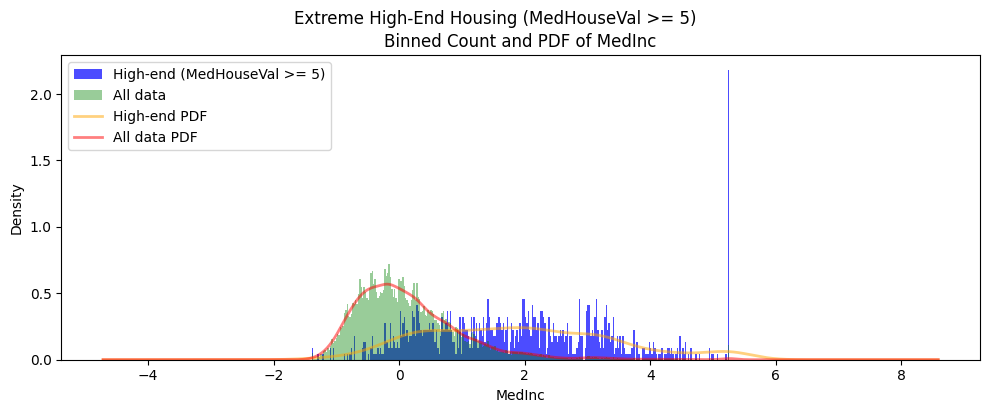

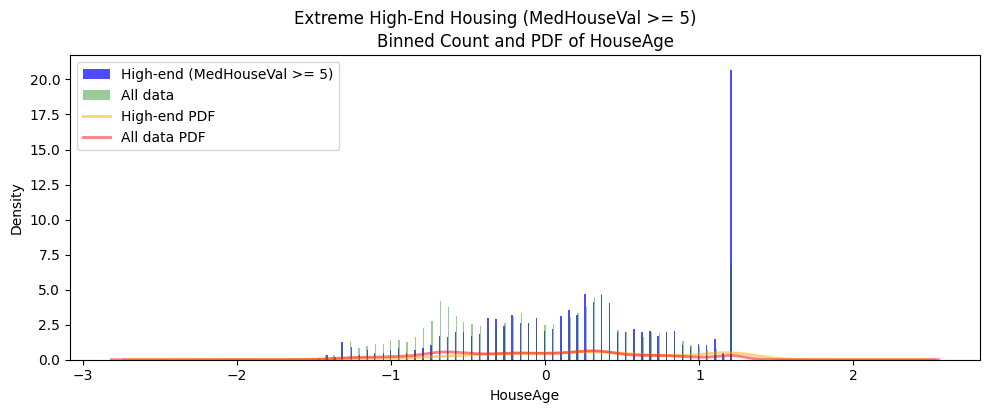

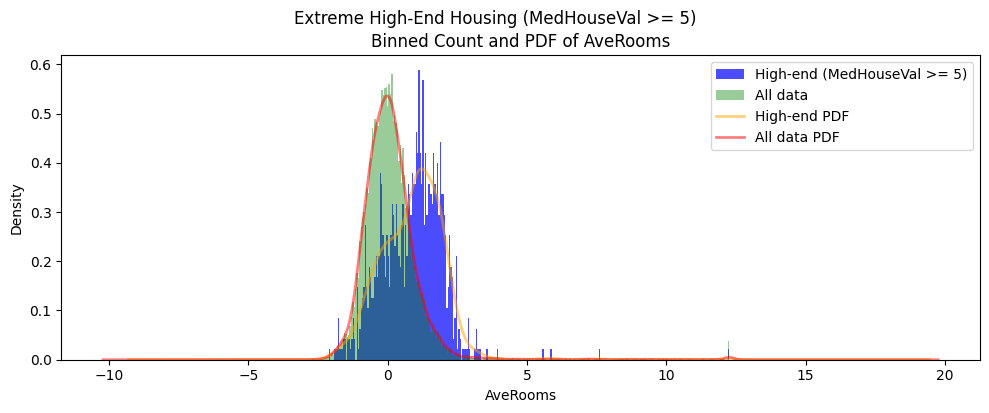

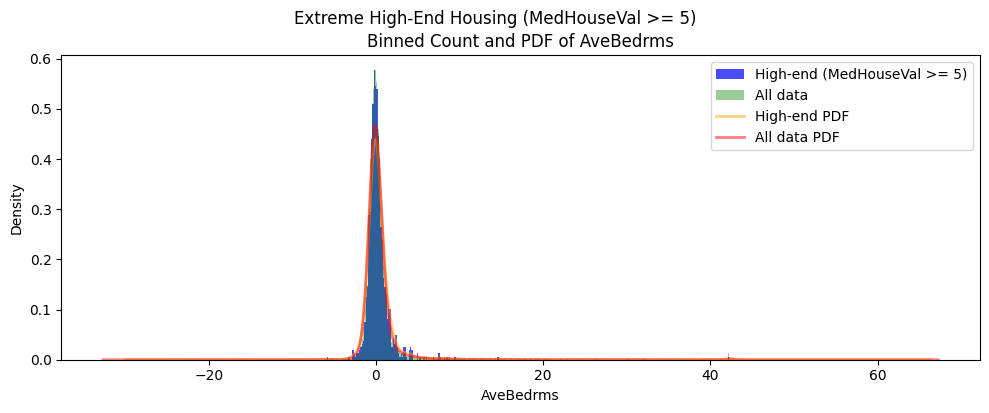

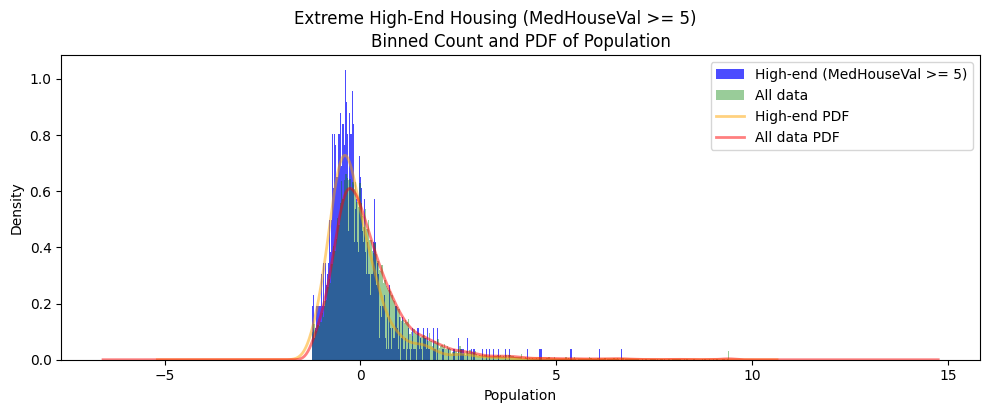

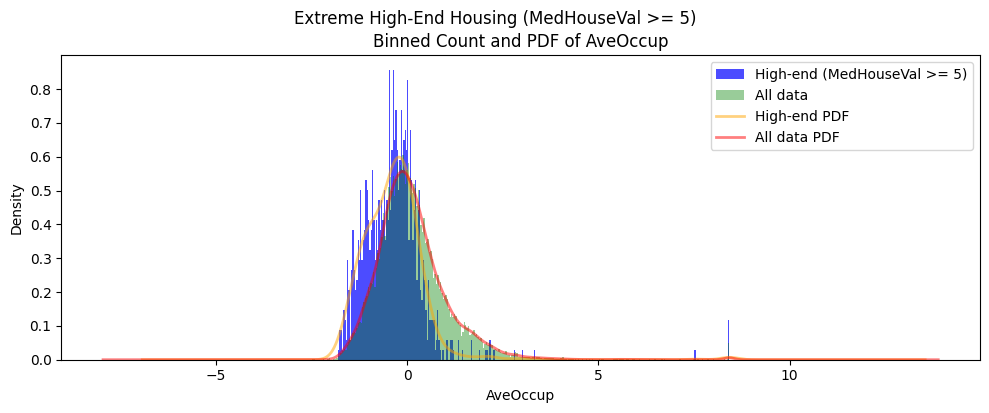

In [164]:
to_chart = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup"]

# Determin relationship between extreme MEDHOUSVAL and other features
extreme_highend_housing_df = housing_df[(housing_df['MedHouseVal'] >= 5)]
extreme_highend_housing_df

# Explore features with histograms and PDFs on the same chart
for feature in to_chart:
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Plot histogram with density normalization
    ax.hist(
        extreme_highend_housing_df[feature],
        bins=300,
        density=True,
        alpha=0.7,
        label='High-end (MedHouseVal >= 5)',
        color='blue'
    )
    ax.hist(
        housing_df[feature],
        bins=300,
        density=True,
        alpha=0.4,
        label='All data',
        color='green'
    )
    
    # Plot PDF for high-end subset
    extreme_highend_housing_df[feature].plot(
        kind='density',
        ax=ax,
        linewidth=2,
        label='High-end PDF',
        color='orange',
        alpha=0.5
    )
    # Plot PDF for full data
    housing_df[feature].plot(
        kind='density',
        ax=ax,
        linewidth=2,
        label='All data PDF',
        color='red',
        alpha=0.5
    )
    
    ax.set_title(f"Binned Count and PDF of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()
    plt.tight_layout()
    plt.suptitle('Extreme High-End Housing (MedHouseVal >= 5)', y=1.02)
    plt.show()

## (Optional) Additional feature engineering

Add more techniques if you'd like to experiment further.

In [165]:
# YOUR CODE HERE (optional)

## Polynomial features

## Use Boosting to help predict MedHouseVal
#from sklearn.ensemble import GradientBoostingRegressor
#X = housing_df.drop('MedHouseVal', axis=1)
#y = housing_df['MedHouseVal']
#model = GradientBoostingRegressor(loss='squared_error', n_estimators=100, random_state=315)
#scores = cross_val_score(model, X, y, cv=5, scoring='r2')




# Feature Selection with Lasso Regression
from sklearn.linear_model import LassoCV
X = housing_df.drop('MedHouseVal', axis=1)
y = housing_df['MedHouseVal']
lasso = LassoCV(cv=5, random_state=315)
lasso.fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = X.columns
# Select features with non-zero importance
selected_features = feature_names[importance > 0]
print("Selected features:", selected_features)
X_selected = X[selected_features]
# Evaluate model with selected features
model = LinearRegression()
scores = cross_val_score(model, X_selected, y, cv=10, scoring='r2')
print("R^2 scores with selected features:", scores)
X_selected

# Remake housing_df with selected features
housing_df = X_selected.copy(deep=True)
housing_df['MedHouseVal'] = y
housing_df

/opt/anaconda3/envs/PiPython/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e+01, tolerance: 2.228e+00
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/PiPython/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e+01, tolerance: 2.228e+00
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/PiPython/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incr

Selected features: Index(['MedInc', 'AveOccup', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc AveOccup',
       'HouseAge AveBedrms', 'AveRooms AveBedrms', 'AveRooms Population',
       'AveBedrms^2', 'AveBedrms AveOccup', 'AveBedrms Longitude',
       'AveOccup^2', 'Latitude^2', 'Longitude^2', 'MedInc^3',
       'MedInc^2 HouseAge', 'MedInc^2 AveOccup', 'MedInc^2 Longitude',
       'MedInc HouseAge AveBedrms', 'MedInc HouseAge Population',
       'MedInc HouseAge AveOccup', 'MedInc HouseAge Longitude',
       'MedInc AveRooms^2', 'MedInc AveRooms AveBedrms',
       'MedInc AveRooms Population', 'MedInc AveRooms Longitude',
       'MedInc AveBedrms^2', 'MedInc AveBedrms Population',
       'MedInc AveBedrms AveOccup', 'MedInc AveBedrms Longitude',
       'MedInc Population^2', 'MedInc Population AveOccup',
       'MedInc AveOccup Latitude', 'MedInc Longitude^2', 'HouseAge^3',
       'HouseAge AveRooms AveBedrms', 'HouseAge AveRooms Po

,MedInc,AveOccup,Longitude,MedInc^2,MedInc HouseAge,MedInc AveRooms,MedInc AveBedrms,MedInc AveOccup,HouseAge AveBedrms,AveRooms AveBedrms,...,geohash_code_9,geohash_code_10,geohash_code_11,geohash_code_12,geohash_code_13,geohash_code_14,geohash_code_15,geohash_code_16,geohash_code_18,MedHouseVal
0,2.197582,-0.307981,-0.986807,3.567069,3.030543,2.480258,2.096922,1.608852,0.576119,0.929996,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.526
1,2.186664,-0.830800,-0.984169,3.542225,0.996577,2.087164,1.896481,1.074964,-0.524536,0.328206,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.585
2,1.707732,-0.018599,-0.989446,2.522385,3.469621,2.604267,1.774337,1.475639,1.282596,1.896260,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.521
3,0.967177,-0.316908,-0.992084,1.214873,2.447259,0.915273,1.010751,0.629735,1.281569,0.427596,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.413
4,0.142854,-0.746784,-0.992084,0.144307,1.309253,0.379526,0.175747,-0.220306,1.302857,0.731248,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.905796,-0.302057,-0.686016,-0.631633,-0.651530,-0.627403,-0.875954,-0.844220,-0.120143,0.137580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781
20636,-0.448655,0.357401,-0.717678,-0.374046,-0.566094,-0.147706,-0.173619,-0.277936,-0.357411,1.424825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.771
20637,-0.841709,-0.577676,-0.720317,-0.603037,-0.774630,-0.567008,-0.816181,-0.850144,-0.594348,0.199827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.923
20638,-0.765007,-0.815121,-0.746702,-0.565590,-0.717271,-0.498895,-0.691172,-0.848600,-0.489574,0.429476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.847


## Model evaluation

Now we'll compare model performance on the original dataset versus your engineered dataset.

### Evaluate datasets

In [166]:
# Create output directory if it doesn't exist
output_directory = 'data/outputs'
Path(output_directory).mkdir(parents=True, exist_ok=True)

# Save a copy of the engineered dataframe
housing_df.to_csv('data/outputs/housing_df.csv', index=False)

In [167]:
# Create linear regression model
model = LinearRegression()

# Evaluate on original dataset
scores_original = cross_val_score(
    model,
    original_housing_df.drop('MedHouseVal', axis=1),
    original_housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

# Evaluate on engineered dataset
scores_engineered = cross_val_score(
    model,
    housing_df.drop('MedHouseVal', axis=1),
    housing_df['MedHouseVal'],
    cv=10,
    scoring='r2'
)

engineered_mean = scores_engineered.mean()
original_mean = scores_original.mean()
mean_improvement = (engineered_mean - original_mean) / original_mean

print(f'\nMean improvement: {mean_improvement:.2f}%')


Mean improvement: 0.25%


### Visualize model performance comparison

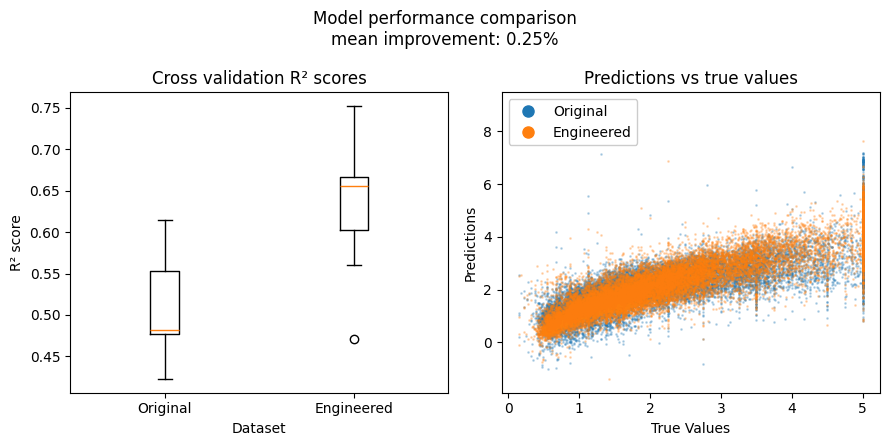

In [168]:
original_model = LinearRegression()
original_model.fit(original_housing_df.drop('MedHouseVal', axis=1), original_housing_df['MedHouseVal'])
original_predictions = original_model.predict(original_housing_df.drop('MedHouseVal', axis=1))

model = LinearRegression()
model.fit(housing_df.drop('MedHouseVal', axis=1), housing_df['MedHouseVal'])
predictions = model.predict(housing_df.drop('MedHouseVal', axis=1))

# Create boxplot comparing performance
data_to_plot = [scores_original, scores_engineered]
labels = ['Original', 'Engineered']

fig, axs = plt.subplots(1, 2, figsize=(9,4.5))

fig.suptitle(f'Model performance comparison\nmean improvement: {mean_improvement:.2f}%')

axs[0].set_title('Cross validation R² scores')
axs[0].boxplot(data_to_plot, tick_labels=labels)
axs[0].set_xlabel('Dataset')
axs[0].set_ylabel('R² score')

axs[1].set_title('Predictions vs true values')
axs[1].plot(
    original_housing_df['MedHouseVal'], original_predictions,
    'o', markersize=1, label='Original', alpha=0.25
)

axs[1].plot(
    housing_df['MedHouseVal'], predictions,
    'o', markersize=1, label='Engineered', alpha=0.25
)

axs[1].set_xlabel('True Values')
axs[1].set_ylabel('Predictions')

leg = axs[1].legend(loc='upper left', markerscale=8, framealpha=1)

for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.tight_layout()
plt.show()

## 3. Reflection

**Questions to consider**:

1. Which feature engineering techniques had the biggest impact on model performance?
2. Did adding more features always improve performance, or did some hurt it?
3. How might you further improve the engineered dataset?
4. What trade-offs did you consider (e.g., interpretability vs performance, complexity vs gains)?

**Your reflection**:

*Write your thoughts here...*